In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 10.1 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt### plotting bar chart
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Reshape, Conv2DTranspose, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, MultiHeadAttention)
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
!pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d jessicali9530/celeba-dataset
!unzip "/content/celeba-dataset.zip" -d "/content/dataset/"

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
unzip:  cannot find or open /content/celeba-dataset.zip, /content/celeba-dataset.zip.zip or /content/celeba-dataset.zip.ZIP.


In [ ]:
!mkdir .kaggle
!touch .kaggle/kaggle.json

api_token = {"username":"aniketyadav0506","key":"141182492d7339e1f4c808da58071c64"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘.kaggle’: File exists


In [ ]:
!kaggle datasets download -d jessicali9530/celeba-dataset
!unzip "/content/celeba-dataset.zip" -d "/content/dataset/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197604.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197605.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197606.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197607.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197608.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197609.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197610.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197611.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197612.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197613.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197614.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197615.jpg  
  inflating: /content/dat

In [ ]:
BATCH_SIZE = 32
TIME_STEPS = 1000
IM_SHAPE = (64,64,3)
N_HEADS = 8
ATTN_DIM = 256
N_GROUPS = 8
N_RESNETS = 2
LEARNING_RATE = 2e-4

In [ ]:
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/dataset/img_align_celeba/img_align_celeba", label_mode=None, image_size=(IM_SHAPE[0], IM_SHAPE[1]), batch_size=32
)

Found 202599 files belonging to 1 classes.


In [ ]:
def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return tf.linspace(beta_start, beta_end, timesteps)

In [ ]:


# define beta schedule
betas = linear_beta_schedule(TIME_STEPS)

# define alphas
alphas = 1. - betas
alphas_cumprod = tf.math.cumprod(alphas, axis=0)
alphas_cumprod_prev = tf.concat([tf.ones((1,)),alphas_cumprod[:-1]],axis = 0)
sqrt_recip_alphas = tf.math.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = tf.math.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = tf.math.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)



In [ ]:
def preprocess(image):
  return tf.cast(image, tf.float32) / 127.5 - 1.0

In [ ]:
train_dataset = (
    ds_train
    .map(preprocess)
    .unbatch()
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .batch(BATCH_SIZE,drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
for d in train_dataset.take(1):
  print(d.shape)

(32, 64, 64, 3)


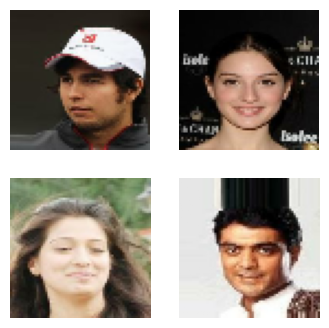

In [ ]:
plt.figure(figsize = (4,4))
k=0
n = 4
for i in range(n):
    ax = plt.subplot(2,2, k+1)
    plt.imshow((d[i]+1)/2)
    plt.axis("off")
    k+=1

In [ ]:
def extract(a, t, x_shape):
  b, *_ = t.shape
  out = tf.gather(a,t)
  output = tf.reshape(out, (b,*((1,) * (len(x_shape) - 1))))
  return output

In [ ]:
def q_sample(x_start, t, noise):

  sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
  sqrt_one_minus_alphas_cumprod_t = extract(
      sqrt_one_minus_alphas_cumprod, t, x_start.shape
  )
  out_sample = sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise
  return out_sample

In [ ]:
x_start = d

t = tf.random.uniform((BATCH_SIZE,),minval=0,maxval=TIME_STEPS, dtype=tf.int32)
print(t)
print(x_start.shape, t.shape, )
sample = q_sample(x_start, t,tf.random.normal(x_start.shape))
print(sample.shape)

tf.Tensor(
[112 290 931  49 237 763  15 234 406 704 307 157 577 573 783 669 507  22
 162 533  74  45 163 698 605 387 152 532 642  97 775 990], shape=(32,), dtype=int32)
(32, 64, 64, 3) (32,)
(32, 64, 64, 3)


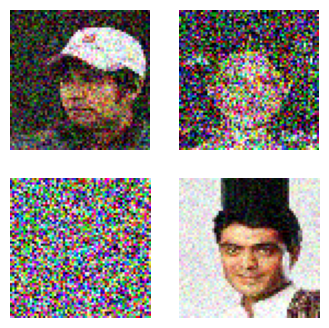

In [ ]:
plt.figure(figsize = (4,4))
k=0
n = 4
for i in range(n):
  ax = plt.subplot(2,2, k+1)
  plt.imshow((sample[i]+1)/2)
  plt.axis("off")
  k+=1

In [ ]:
class PositionalEmbeddings(tf.keras.layers.Layer):

    def __init__(self, dim):
        super().__init__()
        self.embedding_dim = dim

    def get_timestep_embedding(self, timesteps, embedding_dim: int):
        """
        From Fairseq.
        Build sinusoidal embeddings.
        This matches the implementation in tensor2tensor, but differs slightly
        from the description in Section 3.5 of "Attention Is All You Need".
        """
        half_dim = self.embedding_dim // 2
        emb = tf.math.log(10000.) / (half_dim - 1)
        emb = tf.exp(tf.range(half_dim, dtype=tf.float32) * -emb)
        emb = tf.cast(timesteps, dtype = tf.float32)[:, None] * emb[None, :]
        emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=1)
        if embedding_dim % 2 == 1:
            emb = tf.pad(emb, [[0, 0], [0, 1]])
        return emb

    def call(self, time):
        return self.get_timestep_embedding(time, self.embedding_dim)

In [ ]:
def res_block(x,filters,n_groups,temb):
    previous = x
    x = Conv2D(filters, 3, padding="same",)(x) ### Convolution layer with padding same, so that the resolution remains the same

    ### temb represents the time embedding.
    ### It is passed into the silu activation function and a Dense Layer(Which can change the the embedding dimension )
    ### We also reshape the time embedding to match the output of 2d convnets.
    x += Dense(filters)(tf.nn.silu(temb))[:,None,None,:]

    ### Group Normalization is used.
    x = tf.nn.silu(tfa.layers.GroupNormalization(n_groups, axis = -1)(x))
    x = Conv2D(filters, 3, padding="same",)(x)

    # Project residual
    residual = Conv2D(filters, 1,padding="same",)(previous)
    x = tf.keras.layers.add([x, residual])  # Add back residual
    return x

In [ ]:
def get_model(im_shape=(64,64,3),n_resnets=2,n_groups=8,attn_dim=32,n_heads=4,):
    input_1 = Input(shape=im_shape)### image input
    input_2 = Input(shape=())### time input
    t_dim = im_shape[0]*16

    # Entry block
    x = Conv2D(32, 3, padding="same")(input_1)
    temb = PositionalEmbeddings(t_dim)(input_2)### Create embeddings from the time input_2
    temb = Dense(t_dim)(tf.nn.gelu(Dense(t_dim)(temb)))### pass the embedding into the gelu activation function

    hs = [x]### variable used for storing each resolution level output, in the downward path, to be concatenated to the inputs of the upward path.

    ### Downward Path
    for filters in [32, 64, 128, 256]:### for every resolution level (32,64,128,256), represent the depth they map to resolutions of (32,16,8,4)
        for _ in range(n_resnets):### we go through each resnet block per resolution level
            x = res_block(x,filters,n_groups,temb)### resblock
            ### if the resolution=16 (coinciding with a depth=64), we make the resnet output features attend to each other.
            ### Note how the attention axes = (1,2). This corresponds to the height and width dimensions.
            ### Feel free to Check the documentation out :) https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention.
            ### query = key = value = x.
            ### We again use Group Normalization.
            if filters == 64:
                x = tfa.layers.GroupNormalization(groups=n_groups, axis = -1)(
                    MultiHeadAttention(num_heads=n_heads, key_dim=attn_dim, attention_axes=(1,2), )(query = x, value = x))
        hs.append(x)### append the output features to hs
        x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)### Downsampling in order to move to the next resolution level


    ### Bottleneck
    x = res_block(x,256,n_groups,temb)
    x = tfa.layers.GroupNormalization(groups=n_groups, axis = -1)(
      MultiHeadAttention(num_heads=n_heads, key_dim=attn_dim, attention_axes=(1,2), )(query = x, value = x))
    x = res_block(x,256,n_groups,temb)


    ### Upward path
    for filters in [256, 128, 64,32]:
        ### we resize x, to match with the shape of feature outputs (hs) in the downward path
        x = tf.image.resize_with_pad(x,hs[-1].shape[1],hs[-1].shape[2])
        x = tf.concat([x,hs.pop()], axis=-1)

        for _ in range(n_resnets):

            x = res_block(x,filters,n_groups,temb)

            if filters == 64:
                x = tfa.layers.GroupNormalization(groups=n_groups, axis = -1)(
                  MultiHeadAttention(num_heads=n_heads, key_dim=attn_dim, attention_axes=(1,2), )(query = x, value = x))

        if filters != 32:
            x = Conv2DTranspose(filters, 3, strides = (2,2),)(x)### Upsampling

    x = res_block(x,32,n_groups,temb)
    outputs = Conv2D(3, 3, padding="same", )(x)

    # Define the model
    model = Model([input_1,input_2], outputs,name='unet')
    return model





In [ ]:

# Build model
model= get_model(im_shape=IM_SHAPE,n_resnets=N_RESNETS,n_groups=N_GROUPS,attn_dim=ATTN_DIM,n_heads=N_HEADS,)
model.summary()

Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 positional_embeddings (Positio  (None, 1024)        0           ['input_2[0][0]']                
 nalEmbeddings)                                                                                   
                                                                                                  
 dense_1 (Dense)                (None, 1024)         1049600     ['positional_embeddings[0][0]']  
                                                                                                  
 tf.nn.gelu (TFOpLambda)        (None, 1024)         0           ['dense_1[0][0]']             

In [ ]:
OPTIMIZER = Adam(learning_rate = 0.5e-4)

In [ ]:
def custom_loss(denoise_model, x_start, t, noise=None):
  h = tf.keras.losses.Huber()
  noise = tf.random.normal(x_start.shape,mean=0,stddev=1)
  x_noisy = q_sample(x_start,t,noise)

  predicted_noise = denoise_model([x_noisy, t])

  # plt.figure(figsize = (10,10))
  # outs = [x_noisy,noise,predicted_noise]
  # print('predicted------------',predicted_noise)
  # print('actual -------------;',noise)
  # for i in range(3):
  #   ax = plt.subplot(1,3, i+1)
  #   plt.imshow(outs[i][10])
  #   plt.axis("off")

  return h(noise,predicted_noise)#tf.reduce_mean(tf.math.square(noise-predicted_noise))#

In [ ]:
@tf.function
def training_block(x_batch):
  with tf.GradientTape() as recorder:

    t = tf.random.uniform((BATCH_SIZE,),minval=0,maxval=TIME_STEPS,dtype=tf.int32)
    loss = custom_loss(model,x_batch,t)

  partial_derivatives = recorder.gradient(loss, model.trainable_weights)
  OPTIMIZER.apply_gradients(zip(partial_derivatives, model.trainable_weights))
  return loss

In [ ]:
from IPython.display import clear_output

In [ ]:
def longtime(EPOCHS):
  for epoch in range(EPOCHS):
    init_time = time.time()
    losses = []
    for step, x_batch in enumerate(train_dataset):
      loss = training_block(x_batch)
      losses.append(loss)
      if step%5==0:
        print(step)
    clear_output()
    print(str(epoch+1)+"/"+str(EPOCHS)+": Training Loss----->", sum(losses)/len(losses))
    print('Time Elapsed: ---> '+str(time.time()-init_time)+' s')
  model.save('/content/drive/MyDrive/unet')

  print("Training Complete!!!!")

In [ ]:
longtime(200)

0


KeyboardInterrupt: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored